In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import griddata
# import matplotlib.tri as tri

# sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "gtracr"))

from trajectory import Trajectory
from add_location import location_dict
from add_particle import particle_dict

In [2]:
import yep

In [3]:
# create particle trajectory with desired particle and energy
rigidity_list = np.arange(5, 55, 5)
particle_list = [("p+", particle_dict["p+"])
                 ]  #, ("e-", particle_dict["e-"])]
location_list = [("Kamioka", location_dict["Kamioka"])]

# iter_num = 10000  # total number of points used for Monte Carlo process
# # variables used for determining index in which rigidity cutoffs should be located at
# zenith_stepsize = 180. / num  # stepsize for zenith angle
# azimuth_stepsize = 360. / num  # stepsize for azimuth angle

# arrays to append zenith and azimuth angles
# zenith_arr = []
# azimuth_arr = []

# # dictionary to append rigidity cutoff values
# # this is to allow pair of points that are generated randomly
# # to be stored
# rigidity_cutoffdict = {}

# geomag_cutoffdict = {
#     "Zenith": zenith_arr,
#     "Azimuth": azimuth_arr,
#     "Location": {}
# }



In [4]:
loc = location_dict["Kamioka"]

In [5]:
# analytical cutoff rigidities from Stormers equation (Honda2002)
M = 2.416e15   # in GV * m^2 /c  
particle_altitude = (6371.2)*(1e3)
R0 = M / particle_altitude**2.   # in GV/c

print(R0)

59.51883929717884


In [6]:
def stormer(latitude, azimuth, zenith):
    lat = (latitude) * (np.pi / 180.)
    azi = azimuth * (np.pi / 180.)
    zen = zenith * (np.pi / 180.)
    denom = 1 + np.sqrt(1 + ((np.cos(lat))**3.) * np.sin(zen) * np.sin(azi))
    return R0 * ((np.cos(lat))**4. / denom**2.)

In [7]:
print(stormer(0., 90., 270.))

59.51883929717884


In [8]:
rcutoff_analytical_arr = []

In [9]:
def evaluate(iter_num):
    result_arr1 = []
    for i in range(iter_num):
        # get a random zenith and azimuth angle
        # zenith angles range from 0 to 180
        # azimuth angles range from 0 to 360
        [azimuth, zenith] = np.random.rand(2)
        azimuth *= 360.
        zenith *= 180.     
#         print(rigidity_analytical)

#         print("Zenith Angle: {0}, Azimuth Angle {1}\n".format(
#             zenith, azimuth))
        for k, rigidity in enumerate(rigidity_list):
#             print("Current rigidity: {:.4e}".format(rigidity))
            traj = Trajectory("p+",
                              latitude=loc.latitude,
                              longitude=loc.longitude,
                              detector_altitude=loc.altitude,
                              zenith_angle=zenith,
                              azimuth_angle=azimuth,
                              particle_altitude=100.,
                              rigidity=rigidity)
            traj.get_trajectory(max_step=10000)

            if traj.particle_escaped == True:
#                 print(rigidity_analytical)
#                 rigidity_analytical = stormer(loc.latitude, azimuth, zenith)
                result_arr1.append((azimuth, zenith, rigidity))#, rigidity_analytical))
                break
                
    return result_arr1



In [15]:
# %load_ext snakeviz
from google_perftools_wrapped import StartProfiler, StopProfiler

ModuleNotFoundError: No module named 'google_perftools_wrapped'

In [14]:
# %%snakeviz
# import yep
# yep.start("gcutoff_profiling.prof")
iter_num = 1000
result_arr = evaluate(iter_num)
# yep.stop()

In [22]:
# print(result_arr)

In [23]:
    # the azimuth and zenith arrays, obtained from the rigidity cutoff dictionary keys
# that are in the form (azimuth, zenith) for each point
azimuth_arr, zenith_arr, rigidity_cutoffarr, rcutoff_analytical_arr = zip(*result_arr)
rigidity_cutoffarr = np.asarray(rigidity_cutoffarr)
rcutoff_analytical_arr = np.asarray(rcutoff_analytical_arr)
# rcutoff_analytical_arr *= (1e-4)*(1.602e-19) / ((1.79e-27)*(3e8)**2.)
# print(rcutoff_analytical_arr)

In [24]:
locname = "Kamioka"
particle = "p+"

(180.0, 0.0)

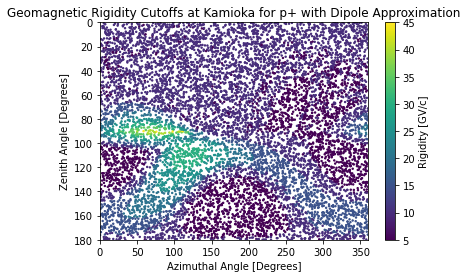

In [110]:
fig1, ax1 = plt.subplots()
im1 = ax1.scatter(azimuth_arr, zenith_arr, c=rigidity_cutoffarr, s=2.0)
ax1.set_xlabel("Azimuthal Angle [Degrees]")
ax1.set_ylabel("Zenith Angle [Degrees]")
ax1.set_title("Geomagnetic Rigidity Cutoffs at {0} for {1} with Dipole Approximation".format(
    locname, particle))

cbar = fig1.colorbar(im1, ax=ax1)
cbar.ax.set_ylabel("Rigidity [GV/c]")

ax1.set_xlim([0., 360.])
ax1.set_ylim([180., 0.])


# fig2, ax2 = plt.subplots()
# cs = ax2.scatter(azimuth_arr, zenith_arr, c=rcutoff_analytical_arr, s=2.0)
# ax2.set_xlabel("Azimuthal Angle [Degrees]")
# ax2.set_ylabel("Zenith Angle [Degrees]")
# ax2.set_title("Stormer Rigidity Cutoffs at {0} for {1} with Dipole Approximation".format(
#     locname, particle))

# cbar = fig2.colorbar(cs, ax=ax2)
# cbar.ax.set_ylabel("Rigidity [GV/c]")

# fig_residual, ax_residual = plt.subplots()
# cs = ax_residual.scatter(azimuth_arr, zenith_arr, c=np.abs(rcutoff_analytical_arr - rigidity_cutoffarr), s=2.0)
# ax_residual.set_xlabel("Azimuthal Angle [Degrees]")
# ax_residual.set_ylabel("Zenith Angle [Degrees]")
# ax_residual.set_title("Residual of Geomagnetic Rigidity Cutoffs at {0} for {1} with Dipole Approximation".format(
#     locname, particle))

# cbar = fig_residual.colorbar(cs, ax=ax_residual)
# cbar.ax.set_ylabel("Residual [GV/c]")

In [104]:
import matplotlib.tri as tri
# perfect for linear!
ngrid_azimuth = 70
ngrid_zenith = 70


# ngrid_azimuth =50
# ngrid_zenith = 50

azimuth_grid = np.linspace(
    np.min(azimuth_arr),
    np.max(azimuth_arr), ngrid_azimuth)
zenith_grid = np.linspace(
    np.max(zenith_arr),
    np.min(zenith_arr), ngrid_zenith)

# triang = tri.Triangulation(azimuth_arr, zenith_arr)
# interpolator = tri.LinearTriInterpolator(triang, rigidity_cutoffarr)
# azimuth_matrix, zenith_matrix = np.meshgrid(azimuth_grid, zenith_grid)
# rigidity_cutoffgrid = interpolator(azimuth_matrix, zenith_matrix)

rigidity_cutoffgrid = griddata(points=(azimuth_arr, zenith_arr),
                               values=rigidity_cutoffarr,
                               xi=(azimuth_grid[None, :],
                                   zenith_grid[:, None]),
                               method='linear')

In [105]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

Text(0.5, 1.0, 'Geomagnetic Rigidity Cutoffs at Kamioka for p+')

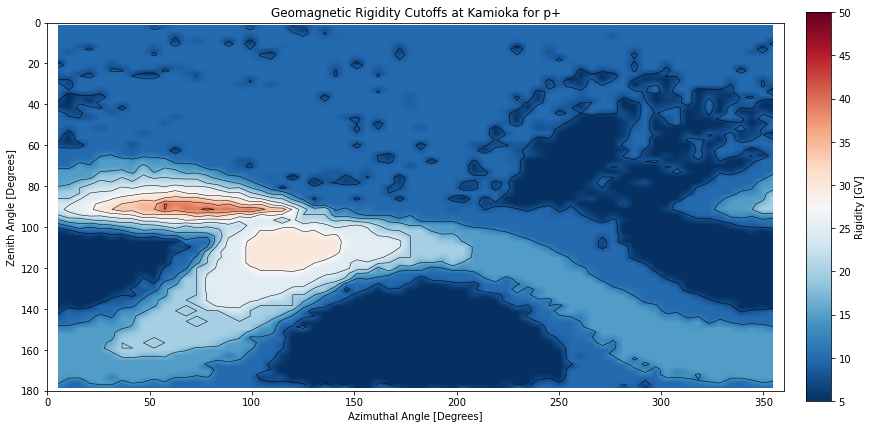

In [111]:
fig, ax = plt.subplots(figsize=(12, 9), constrained_layout=True)
# fig = plt.figure(figsize=(12,9))
# ax = plt.subplot(111)

image = ax.imshow(
    rigidity_cutoffgrid,
    extent=[-2.5, 362.5, -2.5, 182.5], 
#     extent=[0., 360., 0., 180.],
#     extent=[-1, 361, -1, 181],
    origin='upper',
    cmap="RdBu_r",
    interpolation="bilinear",
    aspect="auto",
    vmin=np.min(rigidity_list),
    vmax=np.max(rigidity_list),
    alpha=1.
)
ax.axis('image')

contour = ax.contour(
    azimuth_grid,
    zenith_grid,
    rigidity_cutoffgrid,
    #  levels=rigidity_list,
    colors="k",
#     cmap="viridis",
    linewidths=0.5,
#     extent=[-5., 365., -5., 185.], 
#      extent=[0., 360., 0., 180.],
#     corner_mask=False,
    levels=len(rigidity_list),
    alpha=1.
)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)

# ax.clabel(contour, inline=1, fontsize=10.0)

cbar = fig.colorbar(image, ax=ax, shrink=0.6)
cbar.ax.set_ylabel("Rigidity [GV]")
# cbar.set_clim([np.min(rigidity_list)-0.5, np.max(rigidity_list)+0.5])
# cbar.ax.set_ylim([np.min(rigidity_list)-0.5, np.max(rigidity_list)+0.5])

ax.set_xlim([0., 360.])
ax.set_ylim([180., 0.])

ax.set_xlabel("Azimuthal Angle [Degrees]")
ax.set_ylabel("Zenith Angle [Degrees]")
ax.set_title("Geomagnetic Rigidity Cutoffs at {0} for {1}".format(
    locname, particle))

# fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

ax.tricontour(azimuth_arr, zenith_arr, rigidity_cutoffarr, levels=len(rigidity_cutoffarr),)

In [61]:


ngrid_azimuth = 160
ngrid_zenith = 150

azimuth_grid = np.linspace(
    np.min(azimuth_arr),
    np.max(azimuth_arr), ngrid_azimuth)
zenith_grid = np.linspace(
    np.max(zenith_arr),
    np.min(zenith_arr), ngrid_zenith)

# triang = tri.Triangulation(azimuth_arr, zenith_arr)
# interpolator = tri.LinearTriInterpolator(triang, rigidity_cutoffarr)
# azimuth_matrix, zenith_matrix = np.meshgrid(azimuth_grid, zenith_grid)
# rigidity_cutoffgrid = interpolator(azimuth_matrix, zenith_matrix)

rigidity_cutoffgrid = griddata(points=(azimuth_arr, zenith_arr),
                               values=rigidity_cutoffarr,
                               xi=(azimuth_grid[None, :],
                                   zenith_grid[:, None]),
                               method='cubic')

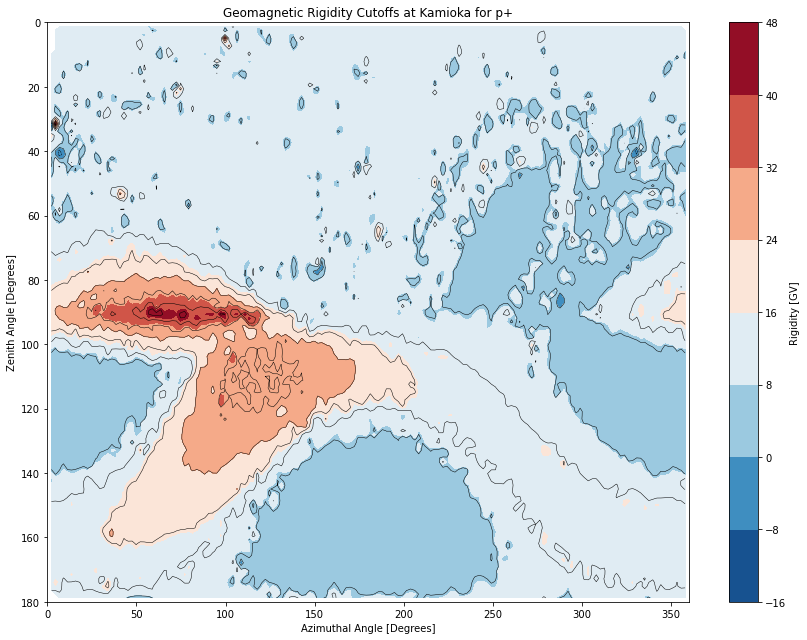

In [62]:
# fig = plt.figure()
# ax = plt.subplot(111, projection="3d")
# ax = plt.subplot(projection="hammer")
fig, ax = plt.subplots(figsize=(12, 9))

# cs = ax.scatter(azimuth_arr, zenith_arr, c=rigidity_cutoffarr, s=2.0)  #,
# vmin=np.min(rigidity_list) - 0.5,
# vmax=np.max(rigidity_list) + 0.5)

# im = ax.pcolormesh(azimuth,
#                    zenith,
#                    rigidity_cutoffarr,
#                    cmap="viridis",
#                    vmin=np.min(rigidity_list) - 0.5,
#                    vmax=np.max(rigidity_list) + 0.5)

ax.contour(
    azimuth_grid,
    zenith_grid,
    rigidity_cutoffgrid,
    #  levels=rigidity_list,
    colors="k",
#     cmap="viridis",
    linewidths=0.5,
    levels=len(rigidity_list))

cs = ax.contourf(
    azimuth_grid,
    zenith_grid,
    rigidity_cutoffgrid,
    #  levels=rigidity_list,
    cmap="RdBu_r")
#     vmin=np.min(rigidity_list) - 0.5,
#                    vmax=np.max(rigidity_list) + 0.5)

# #
# ax.clabel(cs, inline=1, fontsize=10)
cbar = fig.colorbar(cs, ax=ax)
cbar.ax.set_ylabel("Rigidity [GV]")

ax.set_xlim([0., 360.])
ax.set_ylim([180., 0.])

ax.set_xlabel("Azimuthal Angle [Degrees]")
ax.set_ylabel("Zenith Angle [Degrees]")
ax.set_title("Geomagnetic Rigidity Cutoffs at {0} for {1}".format(
    locname, particle))

fig.tight_layout()

In [145]:
    # the azimuth and zenith arrays, obtained from the rigidity cutoff dictionary keys
# that are in the form (azimuth, zenith) for each point
# azimuth_arr, zenith_arr = zip(*list(rigidity_cutoffdict.keys()))
# reshape rigidity_cutoff arrays into a matrix-like structure
# also divide by total number of iterations (normalize)
# rigidity_cutoffarr = np.array(list(rigidity_cutoffdict.values()))

azimuth_grid = np.linspace(
    np.min(azimuth_arr) - 0.5,
    np.max(azimuth_arr) + 0.5, 500)
zenith_grid = np.linspace(
    np.max(zenith_arr) + 0.5,
    np.min(zenith_arr) - 0.5, 500)

# triang = tri.Triangulation(azimuth_arr, zenith_arr)
# interpolator = tri.LinearTriInterpolator(triang, rigidity_cutoffarr)
# azimuth_matrix, zenith_matrix = np.meshgrid(azimuth_grid, zenith_grid)
# rigidity_cutoffgrid = interpolator(azimuth_matrix, zenith_matrix)

rigidity_cutoffgrid = griddata(points=(azimuth_arr, zenith_arr),
                               values=rigidity_cutoffarr,
                               xi=(azimuth_grid[None, :],
                                   zenith_grid[:, None]),
                               method='nearest')